In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

In [2]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
import matplotlib.pylab as pl
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

import fastcluster
from scipy.cluster.hierarchy import dendrogram
import scipy.cluster.hierarchy as hier

import networkx as nx
import networkx.algorithms.community as nxcom
import community
from collections import Counter
import pickle
from collections import defaultdict

In [3]:
comparison_X = 'ATB_v_HC'

#### set parameters for plotting

In [4]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=1.0
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

#### specify directory for pickling objects

In [5]:
#use this path for O2 computing cluster
pickled_objects_dir = '/n/data1/hms/dbmi/farhat/Roger/gatesMRI/Projects/Biomarkers/Data/Pickled Files/'

## [1] Load Data

### Network

In [6]:
G = nx.read_gpickle(pickled_objects_dir + f'Network Files/networks/{comparison_X}.pkl')

In [7]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 3005
Number of edges: 672127
Average degree: 447.3391


In [8]:
num_nodes_overall_network = int(len(G.nodes()))

### Edges Weights for Node Pairs (gene pairs)

In [9]:
edge_weight_dict = nx.get_edge_attributes(G, 'weight') #keys: node pairs; values: edge weights
edge_weight_array = np.array(list(edge_weight_dict.values())) #array of edge weights in graph

In [10]:
len(edge_weight_array)

672127

In [11]:
edge_weight_array.mean()

0.2537207006017215

#### Distribution of Edge Weights in original Network

In [12]:
def prettify_plot(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(False)
    ax.tick_params(labelcolor = 'k')
    ax.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
    ax.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

/home/rv76/anaconda2/envs/py36_MRI_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


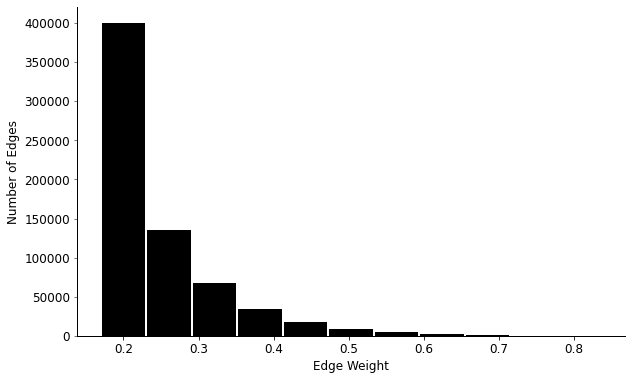

In [13]:
fig = plt.figure(constrained_layout=True)

gs = GridSpec(1, 1, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])

#EDGE WEIGHTS
ax1.hist(edge_weight_array , bins = len(set(edge_weight_array)), color = 'black' , rwidth = 0.95 , edgecolor='white', linewidth=0.0, align='left')

ax1.set_ylabel('Number of Edges', fontsize = 12, color = 'k')
ax1.set_xlabel('Edge Weight' , fontsize = 12, color = 'k')

prettify_plot(ax1)
#ax1.set_yscale('log')
    
################### Plot ###################
fig = plt.gcf()
fig.set_size_inches(9, 5.5)
fig.tight_layout()

#file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

In [14]:
edge_weight_thresholds = np.sort(np.array(list(set(edge_weight_array))))
edge_weight_thresholds

array([0.2       , 0.26666667, 0.33333333, 0.4       , 0.46666667,
       0.53333333, 0.6       , 0.66666667, 0.73333333, 0.8       ,
       0.86666667])

## [2] *Functions* for community detection

### Louvain algorithm

In [15]:
def run_louvain_alg(G, mod_only):
    
    '''
    name: Louvain
    nature: Modularity Optimization
    complexity: O(L) where N = nodes, L = edges, and L~N for sparse networks
    ref: V. D. Blondel, J.-L. Guillaume, R. Lambiotte, and E. Lefebvre. Fast unfolding of communities in large networks. J. Stat. Mech., 2008.
    '''

    # Starting with an initial partition of the graph and running the Louvain algorithm for Community Detection
    partition = community.best_partition(G, weight='weight')
    
    # Grouping dictionary keys by value
    communities = defaultdict(list)
    for key, val in sorted(partition.items()):
        communities[val].append(key)
    communities = list(communities.values())

    # Calculating modularity
    mod = nxcom.modularity(G, communities, weight='weight')

    if mod_only == True:
        
        return mod
        
    else:

        # Creating a dictionary like {community_number:list_of_participants}
        values=[partition.get(node) for node in G.nodes()]
        list_com=partition.values()
        dict_nodes={}

        # Populating the dictionary with items
        for each_item in partition.items():
            community_num=each_item[1]
            community_node=each_item[0]
            if community_num in dict_nodes:
                value=dict_nodes.get(community_num) + ' | ' + str(community_node)
                dict_nodes.update({community_num:value})
            else:
                dict_nodes.update({community_num:community_node})

        # Creating a dataframe from the dict
        community_df=pd.DataFrame.from_dict(dict_nodes, orient='index',columns=['Members'])
        community_df.index.rename('Community_Num' , inplace=True)
        num_comm_members = [len(comm_i_member_list.split(' | ')) for comm_i_member_list in community_df.Members]
        community_df.loc[: , 'Num_Members'] = num_comm_members
        community_df.sort_values(by = 'Num_Members' , ascending = False , inplace = True)
        community_df.reset_index(inplace = True , drop = True)

        # Calculating the total number of communities
        print("Modularity: ", mod)
        print("Total number of Communities =", np.shape(community_df)[0])

        return community_df

### Girvan-Newman algorithm

In [16]:
def run_girvan_alg(G, mod_only):
    
    '''
    name: Girvan-Newman
    nature: Hierarchical Divisive
    complexity: O(N^2) where N = nodes, L = edges, and L~N for sparse networks
    ref: M. Girvan and M.E.J. Newman. Community structure in social and biological networks. PNAS, 99:7821–7826, 2002.
    '''
    
    # Using the Girvan-Newman algorithm to create a Community Structure
    comp=nxcom.girvan_newman(G)

    # Creating a dictionary for the community number assocaited with each node
    com = 0
    thisdict={}

    # Populating the items of the dictionary
    for c in next(comp):
        thislist=sorted(c)
        for i in range(len(thislist)):
            if thislist[i] in thisdict:
                print('already found')
            else:
                thisdict.update({thislist[i]: com})
            i+=1
        com+=1

    # Grouping dictionary keys by value
    communities = defaultdict(list)
    for key, val in sorted(thisdict.items()):
        communities[val].append(key)
    communities = list(communities.values())
    
    # Calculating modularity
    mod = nxcom.modularity(G, communities, weight='weight')

    if mod_only == True:
        
        return mod
        
    else:

        values=[thisdict.get(node) for node in G.nodes()]

        # Creating a dictionary like 'Community num':'List of participants'
        dict_nodes={}
        for each_item in thisdict.items():
            community_num=each_item[1]
            community_node=each_item[0]

            if community_num in dict_nodes:
                value=dict_nodes.get(community_num) + ' | ' + str(community_node)
                dict_nodes.update({community_num: value})
            else:
                dict_nodes.update({community_num: community_node})

        # Creating the output file
        community_df=pd.DataFrame.from_dict(dict_nodes, orient='index',columns=['Members'])
        community_df.index.rename('Community Num', inplace=True)
        num_comm_members = [len(comm_i_member_list.split(' | ')) for comm_i_member_list in community_df.Members]
        community_df.loc[: , 'Num_Members'] = num_comm_members
        community_df.sort_values(by = 'Num_Members' , ascending = False , inplace = True)
        community_df.reset_index(inplace = True , drop = True)

        # Calculating the total number of communities
        print("Modularity:", mod)
        print("Total number of Communities =", np.shape(community_df)[0])
        
        return community_df

### Clauset-Newman-Moore algorithm

In [17]:
def run_clauset_alg(G, mod_only):
    
    '''
    name: Greedy Modularity (optimized)
    nature: Modularity Optimization
    complexity: O(L) where N = nodes, L = edges, and L~N for sparse networks
    ref: A. Clauset, M.E.J. Newman, and C. Moore. Finding community structure in very large networks. Physical Review E, 70:066111, 2004.
    '''

    # Using the Clauset-Newman-Moore algorithm to create a Community Structure
    communities = nxcom.greedy_modularity_communities(G, weight='weight')
    communities = [list(comm_i) for comm_i in communities] #convert from list of frozen sets to list of lists
    
    # Calculate the modularity
    mod = nxcom.modularity(G, communities, weight='weight')

    if mod_only == True:
        
        return mod
        
    else:
        
        # Creating a dictionary for the community number associated with each node
        com = 0
        thisdict = {}

        # Populating the items of the dictionary
        for comm_i in communities: #iterate through communities
            for node_i in comm_i: #iterate through nodes within community
                thisdict[node_i] = com
            #update community ID
            com += 1

        # Creating a dictionary like 'Community num':'List of participants'
        values=[thisdict.get(node) for node in G.nodes()]
        dict_nodes={}
        for each_item in thisdict.items():
            community_num=each_item[1]
            community_node=each_item[0]

            if community_num in dict_nodes:
                value=dict_nodes.get(community_num) + ' | ' + str(community_node)
                dict_nodes.update({community_num: value})
            else:
                dict_nodes.update({community_num: community_node})

        # Creating the output file
        community_df=pd.DataFrame.from_dict(dict_nodes, orient='index',columns=['Members'])
        community_df.index.rename('Community Num', inplace=True)
        num_comm_members = [len(comm_i_member_list.split(' | ')) for comm_i_member_list in community_df.Members]
        community_df.loc[: , 'Num_Members'] = num_comm_members
        community_df.sort_values(by = 'Num_Members' , ascending = False , inplace = True)
        community_df.reset_index(inplace = True , drop = True)

        # Calculation of number of communities
        print("Modularity:", mod)
        print("Total number of Communities =", np.shape(community_df)[0])
        
        return community_df

## [3] Calculate (mean edge weight), (mean weighted degree), (num edges), (num nodes) & (community modularities) for subgraphs induced by highest weighted *edges*

In [18]:
def get_characteristics_of_subgraph(edge_weight_thresh):
    
    '''
    (1) This function returns the mean (edge weight) & (weighted degree) of the subgraph induced by the edges 
    that pass the edge weight threshold in the larger network.
    
    (2) Function returns the (# Edges) and (# Nodes) for these different subgraphs.
    
    (3) Function also returns the modularity after running a community detection
    algorithm on the subgraph
    '''
    
    #get the EDGE WEIGHTS for edges in the network that pass the edge weight threshold
    edge_weight_dict_subset = {key:value for key, value in edge_weight_dict.items() if value >= edge_weight_thresh}
    edge_weight_array_subset = np.array(list(edge_weight_dict_subset.values()))

    #get the SUBGRAPH induced by the most heavily weighted edges
    S = G.edge_subgraph(list(edge_weight_dict_subset.keys()))

    #Get a series of the WEIGHTED DEGREE for each node in the subgraph 
    node_list = [node_deg[0] for node_deg in list(S.degree(weight = 'weight'))]
    degree_list = [node_deg[1] for node_deg in list(S.degree(weight = 'weight'))]
    subgraph_weighted_degree_series = pd.Series(degree_list , index = node_list).sort_values(ascending = False)
    
    #run algorithms for COMMUNITY detection and return MODULARITY
    mod_louvain = run_louvain_alg(S, True)
    mod_girvan = run_girvan_alg(S, True)
    mod_clauset = run_clauset_alg(S, True)
    
    return [edge_weight_array_subset.mean() , subgraph_weighted_degree_series.mean() , float(len(edge_weight_array_subset)) , float(len(node_list)) , mod_louvain, mod_girvan, mod_clauset]

#### Iterate through subnetworks of various sizes for different *edge weight thresholds* in original network

In [19]:
mean_edge_weight_for_subnetworks_list = []
mean_weighted_deg_for_subnetworks_list = []
num_edges_for_subnetworks_list = []
num_nodes_for_subnetworks_list = []
louvain_modularity_for_subnetworks_list = []
girvan_modularity_for_subnetworks_list = []
clauset_modularity_for_subnetworks_list = []

for edge_weight_thresh in edge_weight_thresholds:
    
    subgraph_mean_edge_weight , subgraph_mean_weighted_deg , subgraph_num_edges , subgraph_num_nodes , subgraph_comm_mod_louvain , subgraph_comm_mod_girvan , subgraph_comm_mod_clauset = get_characteristics_of_subgraph(edge_weight_thresh)
    
    mean_edge_weight_for_subnetworks_list.append(subgraph_mean_edge_weight)
    mean_weighted_deg_for_subnetworks_list.append(subgraph_mean_weighted_deg)
    num_edges_for_subnetworks_list.append(subgraph_num_edges)
    num_nodes_for_subnetworks_list.append(subgraph_num_nodes)
    louvain_modularity_for_subnetworks_list.append(subgraph_comm_mod_louvain)
    girvan_modularity_for_subnetworks_list.append(subgraph_comm_mod_girvan)
    clauset_modularity_for_subnetworks_list.append(subgraph_comm_mod_clauset)
    
    print(edge_weight_thresh)
    
#convert to arrays
mean_edge_weight_for_subnetworks = np.array(mean_edge_weight_for_subnetworks_list)
mean_weighted_deg_for_subnetworks = np.array(mean_weighted_deg_for_subnetworks_list)
num_edges_for_subnetworks = np.array(num_edges_for_subnetworks_list)
num_nodes_for_subnetworks = np.array(num_nodes_for_subnetworks_list)
louvain_modularity_for_subnetworks = np.array(louvain_modularity_for_subnetworks_list)
girvan_modularity_for_subnetworks = np.array(girvan_modularity_for_subnetworks_list)
clauset_modularity_for_subnetworks = np.array(clauset_modularity_for_subnetworks_list)

0.2
0.26666666666666666
0.3333333333333333
0.4
0.4666666666666667
0.5333333333333333
0.6
0.6666666666666666
0.7333333333333333
0.8
0.8666666666666667


#### Plot various characteristics of subgraphs induced by highest weighted edges

/home/rv76/anaconda2/envs/py36_MRI_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:84: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


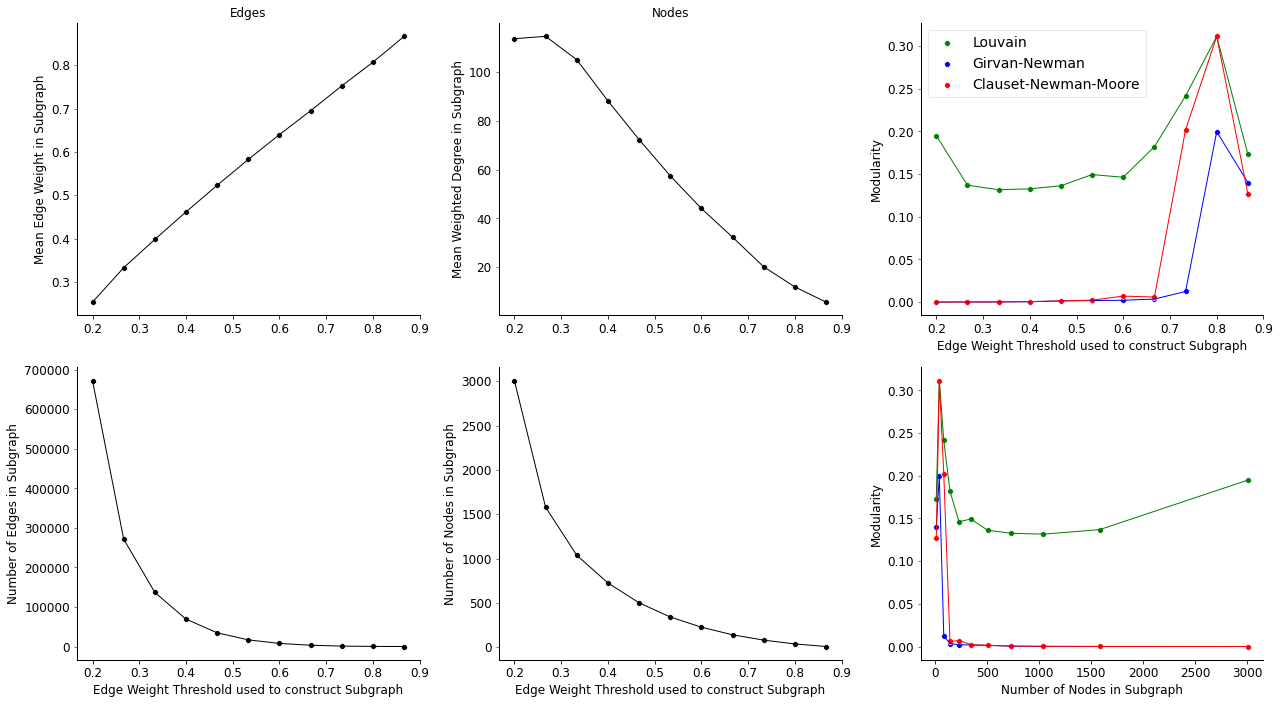

In [27]:
fig = plt.figure(constrained_layout=True)

gs = GridSpec(2, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[0, 2])
ax6 = fig.add_subplot(gs[1, 2])

#EDGE WEIGHT
ax1.scatter(edge_weight_thresholds, mean_edge_weight_for_subnetworks , color = 'black' , linewidth=0.75 , edgecolor = 'white' , s = 35 , alpha = 1.0)
ax1.plot(edge_weight_thresholds, mean_edge_weight_for_subnetworks , color = 'black' , linewidth=1.0)

ax1.set_ylabel('Mean Edge Weight in Subgraph', fontsize = 12, color = 'k')
ax1.set_title('Edges', fontsize = 12, color = 'k')

prettify_plot(ax1)
    
#WEIGHTED DEGREE
ax2.scatter(edge_weight_thresholds, mean_weighted_deg_for_subnetworks , color = 'black' , linewidth=0.75 , edgecolor = 'white' , s = 35 , alpha = 1.0)
ax2.plot(edge_weight_thresholds, mean_weighted_deg_for_subnetworks , color = 'black' , linewidth=1.0)

ax2.set_ylabel('Mean Weighted Degree in Subgraph', fontsize = 12, color = 'k')
ax2.set_title('Nodes', fontsize = 12, color = 'k')

prettify_plot(ax2)

#NUMBER OF EDGES
ax3.scatter(edge_weight_thresholds, num_edges_for_subnetworks , color = 'black' , linewidth=0.75 , edgecolor = 'white' , s = 35 , alpha = 1.0)
ax3.plot(edge_weight_thresholds, num_edges_for_subnetworks , color = 'black' , linewidth=1.0)

ax3.set_ylabel('Number of Edges in Subgraph', fontsize = 12, color = 'k')
ax3.set_xlabel('Edge Weight Threshold used to construct Subgraph' , fontsize = 12, color = 'k')

prettify_plot(ax3)

#NUMBER OF NODES
ax4.scatter(edge_weight_thresholds, num_nodes_for_subnetworks , color = 'black' , linewidth=0.75 , edgecolor = 'white' , s = 35 , alpha = 1.0)
ax4.plot(edge_weight_thresholds, num_nodes_for_subnetworks , color = 'black' , linewidth=1.0)

ax4.set_ylabel('Number of Nodes in Subgraph', fontsize = 12, color = 'k')
ax4.set_xlabel('Edge Weight Threshold used to construct Subgraph' , fontsize = 12, color = 'k')

prettify_plot(ax4)

#MODULARITY
#for communities detected in subnetworks using Lovain, Girvan-Newman, Clauset-Newman-Moore Algorithms
ax5.scatter(edge_weight_thresholds, louvain_modularity_for_subnetworks , color = 'green' , linewidth=0.75 , edgecolor = 'white' , s = 35 , alpha = 1.0, label = 'Louvain')
ax5.plot(edge_weight_thresholds, louvain_modularity_for_subnetworks , color = 'green' , linewidth=1.0)

ax5.scatter(edge_weight_thresholds, girvan_modularity_for_subnetworks , color = 'blue' , linewidth=0.75 , edgecolor = 'white' , s = 35 , alpha = 1.0 , label = 'Girvan-Newman')
ax5.plot(edge_weight_thresholds, girvan_modularity_for_subnetworks , color = 'blue' , linewidth=1.0)

ax5.scatter(edge_weight_thresholds, clauset_modularity_for_subnetworks , color = 'red' , linewidth=0.75 , edgecolor = 'white' , s = 35 , alpha = 1.0 , label = 'Clauset-Newman-Moore')
ax5.plot(edge_weight_thresholds, clauset_modularity_for_subnetworks , color = 'red' , linewidth=1.0)

ax5.set_ylabel('Modularity', fontsize = 12, color = 'k')
ax5.set_xlabel('Edge Weight Threshold used to construct Subgraph' , fontsize = 12, color = 'k')
#ax5.set_title('Communities detected from Lovain Algorithm', fontsize = 12, color = 'k')
ax5.legend(loc="upper left", fancybox = False)

prettify_plot(ax5)

#MODULARITY v. NUMBER OF NODES
ax6.scatter(num_nodes_for_subnetworks , louvain_modularity_for_subnetworks, color = 'green' , linewidth=0.75 , edgecolor = 'white' , s = 35 , alpha = 1.0)
ax6.plot(num_nodes_for_subnetworks , louvain_modularity_for_subnetworks, color = 'green' , linewidth=1.0)

ax6.scatter(num_nodes_for_subnetworks , girvan_modularity_for_subnetworks, color = 'blue' , linewidth=0.75 , edgecolor = 'white' , s = 35 , alpha = 1.0)
ax6.plot(num_nodes_for_subnetworks , girvan_modularity_for_subnetworks, color = 'blue' , linewidth=1.0)

ax6.scatter(num_nodes_for_subnetworks , clauset_modularity_for_subnetworks, color = 'red' , linewidth=0.75 , edgecolor = 'white' , s = 35 , alpha = 1.0)
ax6.plot(num_nodes_for_subnetworks , clauset_modularity_for_subnetworks, color = 'red' , linewidth=1.0)

ax6.set_ylabel('Modularity', fontsize = 12, color = 'k')
ax6.set_xlabel('Number of Nodes in Subgraph' , fontsize = 12, color = 'k')

prettify_plot(ax6)
    
################### Plot ###################
fig = plt.gcf()
fig.set_size_inches(18, 10)
fig.tight_layout()

#file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

Using modularity calculations from the **Louvain** algorithm

In [28]:
optimal_edge_weight_thresh = edge_weight_thresholds[louvain_modularity_for_subnetworks == np.max(louvain_modularity_for_subnetworks)][0]

In [29]:
optimal_edge_weight_thresh

0.8

## [4] Get sub-network constructed from most heavily weighted edges within the network & detect communities

In [19]:
optimal_edge_weight_thresh = 0.8

### [4.1] Get most heavily weighted edges that pass optimal threshold & construct sub-graph

In [20]:
#get the edges in the network that pass the edge weight threshold
edge_weight_dict_subset = {key:value for key, value in edge_weight_dict.items() if value >= optimal_edge_weight_thresh}

#get the SUBGRAPH induced by the most heavily weighted edges
S = G.edge_subgraph(list(edge_weight_dict_subset.keys()))

In [21]:
print(nx.info(S))

Name: 
Type: Graph
Number of nodes: 38
Number of edges: 282
Average degree:  14.8421


Use **Spring Layout** to set the positions of the nodes

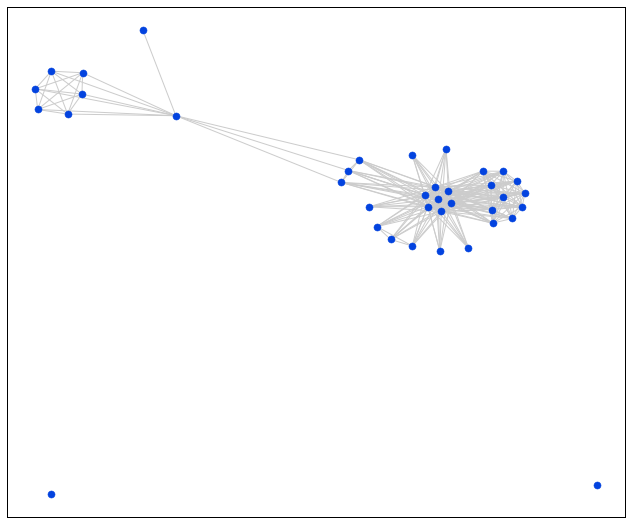

In [63]:
pos = nx.spring_layout(S , weight = 'weight' , iterations = 150 , k = 0.8)

fig , ax = plt.subplots()

nx.draw_networkx(
    S, 
    pos = pos, 
    ax = ax,
    node_size = 50, 
    node_color = 'xkcd:blue',
    edge_color = "0.8",
    alpha = 1.0, 
    with_labels = False)

fig = plt.gcf()
fig.set_size_inches(9.0, 7.5)
fig.tight_layout()
plt.show()

### [4.2] Run *Louvain* algorithm on sub-network and return communities

In [64]:
community_df = run_louvain_alg(S, False)

Modularity:  0.31133596833603927
Total number of Communities = 5


In [65]:
community_df

,Members,Num_Members
0,CARD16 | TLR5 | KLRB1 | TNFSF13B | GBP4 | ANKR...,18
1,LAP3 | EPSTI1 | STAT1 | FBXO6 | XAF1 | PARP9 |...,10
2,KCNJ15 | LHFPL2 | ADM | EPB41L3 | IL1B | GK | ...,8
3,IL7R,1
4,FAM26F,1


Save for community comparison across networks in downstream analysis

In [66]:
community_df.to_pickle(pickled_objects_dir + f'Network Files/communities in subnetworks/{comparison_X}.pkl')

### [4.3] Visualize communites within sub-network & corresponding genes in volcano plot (for all networks)

#### Load data for *all* networks

Weighted Degrees for Nodes (genes)

In [67]:
weighted_deg_ATB_HC_series = pd.read_pickle(pickled_objects_dir + 'Network Files/weighted degree series/ATB_v_HC.pkl')
weighted_deg_ATB_LTBI_series = pd.read_pickle(pickled_objects_dir + 'Network Files/weighted degree series/ATB_v_LTBI.pkl')
weighted_deg_ATB_OD_series = pd.read_pickle(pickled_objects_dir + 'Network Files/weighted degree series/ATB_v_OD.pkl')

Mean $log_2(Fold Change)$ for Nodes (genes)

In [68]:
mean_logFC_ATB_HC_series = pd.read_pickle(pickled_objects_dir + 'Network Files/mean logFC network nodes series/ATB_v_HC.pkl')
mean_logFC_ATB_LTBI_series = pd.read_pickle(pickled_objects_dir + 'Network Files/mean logFC network nodes series/ATB_v_LTBI.pkl')
mean_logFC_ATB_OD_series = pd.read_pickle(pickled_objects_dir + 'Network Files/mean logFC network nodes series/ATB_v_OD.pkl')

Compile into DataFrames

In [69]:
#ATB v HC
ATB_HC_df = pd.DataFrame(index = mean_logFC_ATB_HC_series.index)
ATB_HC_df['mean_log2FC'] = mean_logFC_ATB_HC_series.values
ATB_HC_df['weighted_degree'] = weighted_deg_ATB_HC_series[mean_logFC_ATB_HC_series.index].values

#ATB v LTBI
ATB_LTBI_df = pd.DataFrame(index = mean_logFC_ATB_LTBI_series.index)
ATB_LTBI_df['mean_log2FC'] = mean_logFC_ATB_LTBI_series.values
ATB_LTBI_df['weighted_degree'] = weighted_deg_ATB_LTBI_series[mean_logFC_ATB_LTBI_series.index].values

#ATB v OD
ATB_OD_df = pd.DataFrame(index = mean_logFC_ATB_OD_series.index)
ATB_OD_df['mean_log2FC'] = mean_logFC_ATB_OD_series.values
ATB_OD_df['weighted_degree'] = weighted_deg_ATB_OD_series[mean_logFC_ATB_OD_series.index].values

#### *Function* to color a subset of nodes differently

In [70]:
def draw_graph_and_color_subset_nodes(G, nodes_in_group, ax):

    '''
    This function takes in a graph, list of a subset of nodes and axis object,
    then draws the network with the subset of nodes colored seperately from the 
    rest of the nodes in the network
    '''

    #draw nodes NOT in the (subset) group
    size_map = []
    for node in G:
        if node not in nodes_in_group:
            size_map.append(35)
        elif node in nodes_in_group:
            size_map.append(0)

    nx.draw_networkx(
        G, 
        ax = ax,
        pos=pos, 
        node_size=size_map, 
        node_color = "0.7",
        linewidths = 0.0,
        edge_color="0.7",
        width=0.25,
        alpha=0.75, 
        with_labels=False)

    #draw nodes that ARE in the (subset) group
    size_map = []
    for node in G:
        if node not in nodes_in_group:
            size_map.append(0)
        elif node in nodes_in_group:
            size_map.append(35)

    nx.draw_networkx(
        G, 
        pos=pos, 
        ax = ax,
        node_size=size_map, 
        node_color = 'xkcd:black',
        linewidths = 0.0,
        edge_color="0.7",
        width=0.25,
        alpha=0.7, 
        with_labels=False)

#### *Function* to visualize a set of genes in *mean log2(FC)* vs. *weighted degree* for all networks

In [71]:
def draw_community_subgraph_network_and_plot_logFC_v_meanlogFC_all_networks(G, comm_i):
    
    fig = plt.figure(constrained_layout=True)

    gs = GridSpec(2, 2, figure=fig)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])
    
    ################### VISUALIZE COMMUNITY ###################
    #get the set of nodes within the community
    nodes_in_community = set(community_df.loc[comm_i, 'Members'].split(' | '))
    number_of_nodes = len(nodes_in_community)

    #get the subgraph generated by nodes in community
    G_community_subgraph = G.subgraph(list(nodes_in_community)) 

    #draw the network & color the community differently
    draw_graph_and_color_subset_nodes(G, nodes_in_community, ax1)
    
    ax1.set_title(f'Community {comm_i} with {number_of_nodes} members', fontsize = 12, color = 'k')
    
    ################### ATB_HC ###################
    #get the gene list corresponding to this community
    gene_list = community_df.loc[comm_i,'Members'].split(' | ')
    
    ax2.scatter(ATB_HC_df.weighted_degree, ATB_HC_df.mean_log2FC , color = "0.7" , linewidth=0.0 , edgecolor = 'black' , s = 30 , alpha = 0.5)

    #filter for nodes in gene list
    gene_list_filter = [gene_i in gene_list for gene_i in ATB_HC_df.index]

    #highlight the top N nodes by weighted degree
    ax2.scatter(ATB_HC_df[gene_list_filter].weighted_degree , ATB_HC_df[gene_list_filter].mean_log2FC , color = 'black' , linewidth=0.25 , edgecolor = 'white' , s = 30 , alpha = 1.0)

    ax2.set_title('ATB v HC', fontsize = 12, color = 'k')
    ax2.set_ylabel('Mean log2(FC)', fontsize = 12, color = 'k')
    #ax2.set_xlabel('Weighted Degree' , fontsize = 12, color = 'k')

    prettify_plot(ax2)

    ################### ATB_LTBI ###################
    ax3.scatter(ATB_LTBI_df.weighted_degree, ATB_LTBI_df.mean_log2FC , color = "0.7" , linewidth=0.0 , edgecolor = 'black' , s = 30 , alpha = 0.5)

    #filter for nodes in gene list
    gene_list_filter = [gene_i in gene_list for gene_i in ATB_LTBI_df.index]

    #highlight the top N nodes by weighted degree
    ax3.scatter(ATB_LTBI_df[gene_list_filter].weighted_degree , ATB_LTBI_df[gene_list_filter].mean_log2FC , color = 'black' , linewidth=0.25 , edgecolor = 'white' , s = 30 , alpha = 1.0)

    ax3.set_title('ATB v LTBI', fontsize = 12, color = 'k')
    ax3.set_ylabel('Mean log2(FC)', fontsize = 12, color = 'k')
    ax3.set_xlabel('Weighted Degree' , fontsize = 12, color = 'k')

    prettify_plot(ax3)

    ################### ATB_OD ###################
    ax4.scatter(ATB_OD_df.weighted_degree, ATB_OD_df.mean_log2FC , color = "0.7" , linewidth=0.0 , edgecolor = 'black' , s = 30 , alpha = 0.5)

    #filter for nodes in gene list
    gene_list_filter = [gene_i in gene_list for gene_i in ATB_OD_df.index]

    #highlight the top N nodes by weighted degree
    ax4.scatter(ATB_OD_df[gene_list_filter].weighted_degree , ATB_OD_df[gene_list_filter].mean_log2FC , color = 'black' , linewidth=0.25 , edgecolor = 'white' , s = 30 , alpha = 1.0)

    ax4.set_title('ATB v OD', fontsize = 12, color = 'k')
    ax4.set_ylabel('Mean log2(FC)', fontsize = 12, color = 'k')
    ax4.set_xlabel('Weighted Degree' , fontsize = 12, color = 'k')

    prettify_plot(ax4)

    ################### Plot ###################
    fig = plt.gcf()
    fig.set_size_inches(9.5, 9.5)
    fig.tight_layout()

    #file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
    #plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

    plt.show()

In [72]:
community_df

,Members,Num_Members
0,CARD16 | TLR5 | KLRB1 | TNFSF13B | GBP4 | ANKR...,18
1,LAP3 | EPSTI1 | STAT1 | FBXO6 | XAF1 | PARP9 |...,10
2,KCNJ15 | LHFPL2 | ADM | EPB41L3 | IL1B | GK | ...,8
3,IL7R,1
4,FAM26F,1


Community 0

In [73]:
for gene_i in community_df.loc[0,'Members'].split(' | '):
    print(gene_i)

CARD16
TLR5
KLRB1
TNFSF13B
GBP4
ANKRD22
GBP5
AIM2
FCGR1B
PIK3IP1
DUSP3
CCR7
SAMD9L
GBP2
SERPING1
IFITM3
VAMP5
SORT1


/home/rv76/anaconda2/envs/py36_MRI_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


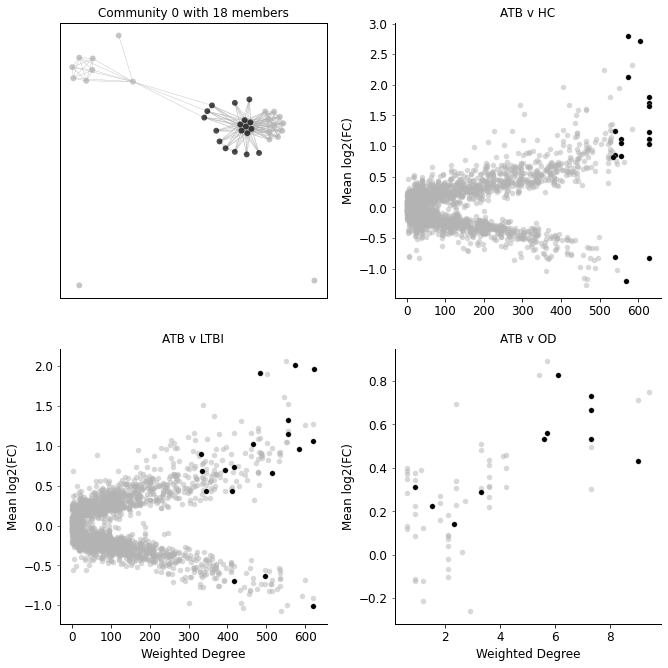

In [74]:
draw_community_subgraph_network_and_plot_logFC_v_meanlogFC_all_networks(S, 0)

Community 1

In [75]:
for gene_i in community_df.loc[1,'Members'].split(' | '):
    print(gene_i)

LAP3
EPSTI1
STAT1
FBXO6
XAF1
PARP9
JAK2
STK3
TNFSF10
TLR7


/home/rv76/anaconda2/envs/py36_MRI_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


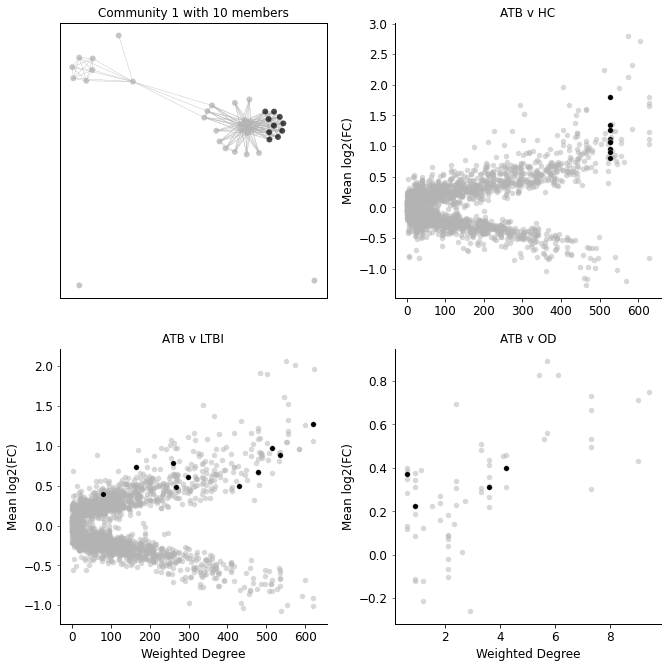

In [76]:
draw_community_subgraph_network_and_plot_logFC_v_meanlogFC_all_networks(S, 1)

Community 2

In [77]:
for gene_i in community_df.loc[2,'Members'].split(' | '):
    print(gene_i)

KCNJ15
LHFPL2
ADM
EPB41L3
IL1B
GK
KCNJ2
DRAM1


/home/rv76/anaconda2/envs/py36_MRI_virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


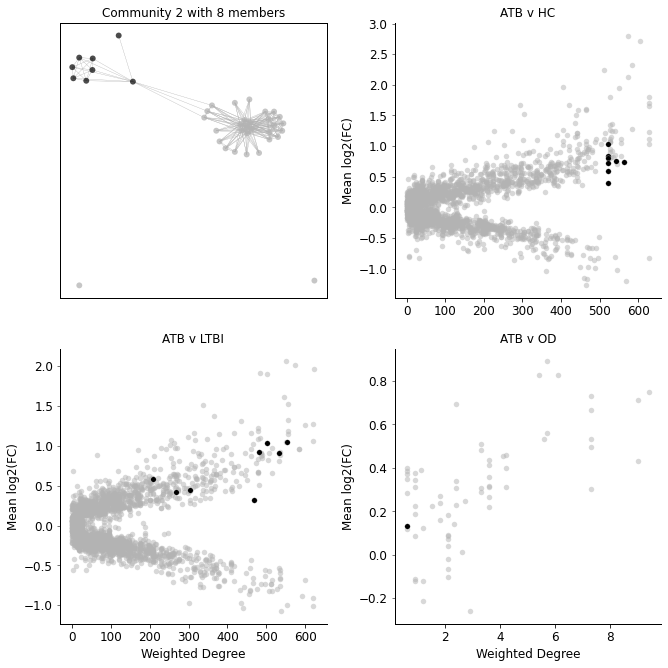

In [78]:
draw_community_subgraph_network_and_plot_logFC_v_meanlogFC_all_networks(S, 2)

### [4.4] Visualize communites within sub-network as seperate colors

In [79]:
community_df

,Members,Num_Members
0,CARD16 | TLR5 | KLRB1 | TNFSF13B | GBP4 | ANKR...,18
1,LAP3 | EPSTI1 | STAT1 | FBXO6 | XAF1 | PARP9 |...,10
2,KCNJ15 | LHFPL2 | ADM | EPB41L3 | IL1B | GK | ...,8
3,IL7R,1
4,FAM26F,1


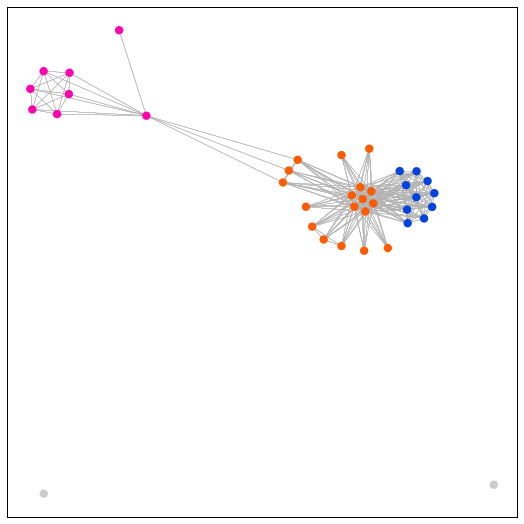

In [82]:
fig , ax = plt.subplots()

color_list = ['xkcd:bright orange' , 'xkcd:blue' , 'xkcd:bright pink'] + ['0.8'] * sum(community_df.Num_Members == 1)

#iterate through each community and color differently
for comm_i in community_df.index:
    
    comm_i_color = color_list[comm_i]
    nodes_in_community = set(community_df.loc[comm_i, 'Members'].split(' | '))
    
    size_map = []
    for node in S:
        if node not in nodes_in_community:
            size_map.append(0)
        elif node in nodes_in_community:
            size_map.append(70)

    nx.draw_networkx(
        S, 
        pos=pos, 
        ax = ax,
        node_size=size_map, 
        node_color = comm_i_color,
        linewidths = 0.0,
        edge_color="0.7",
        width=0.25,
        alpha=1.0, 
        with_labels=False)
    
fig = plt.gcf()
fig.set_size_inches(7.5, 7.5)
fig.tight_layout()

#file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()